In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import editdistance
import re

# Loading the data

Latin1 or iso-8859-1 encoding seem to be not giving any error. Also tested : 
- UTF-8 : codec can't decode byte 0xa3 in position 55: invalid start byte



In [2]:
with open("WELLCOME_APCspend2013_forThinkful.csv", 'rt',encoding="iso-8859-1") as f:
    data = pd.read_csv(f)

In [3]:
data.sample(10)

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
1850,23337727 PMC3651585,The Endocrine Society,Journal of Clinical Endocrinology and Metabolism,Genotype and phenotype correlation,£1909.00
1103,PMCID:\n PMC3610641,Nature Publishing Group,Mucosal Immunology,Endogenous IL-21 regulates pathogenic mucosal ...,£3000.00
509,23773550 PMC3807794,Elsevier,Consciousness and Cognition,Do infants provide evidence that the mirror sy...,£1319.74
925,PMC3083914,International Union of Crystallography,J Synchrotron Radiat.,Assessment of radiation damage behaviour in a ...,£746.90
1537,PMC3561448\n,Public Library of Science,PLoS ONE,Primed Infusion with Delayed Equilibrium of Gd...,£879.33
1662,PMC3652708,Sage,History of the Human Sciences,Making the cut: the production of 'self-harm' ...,£1920.00
2095,PMID: 23750903,Wiley-Blackwell,Molecular Microbiology,Genetic and structural validation of Aspergill...,£1994.65
1384,PMC3681629,Public Library of Science,PLoS Genetics,Causes and consequences of chromatin variation...,£1807.60
305,PMC3624963,BMJ Group,BMJ,Orlistat and the risk of acute liver injury: a...,£3600.00
949,22925518 PMC3593001,John Wiley & Sons Ltd,Development Science,Nine-month-old infants do not need to know wha...,£2351.81


# Structure

5 columns, with missing value mostly in the first column.
- PMID/PMCID, renamed without special character, old w few missing values and does not seem to be useful for the rest of the study : dropped
- Publisher: renamed with lowercase
- Journal title: renamed with lowercase and no space, one missing value but apparently it is a book, to be dropped for the first part of the study...

The list of journal can be confirmed with Wikipedia : [Wiki](https://en.wikipedia.org/wiki/List_of_scientific_journals)


In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2127 entries, 0 to 2126
Data columns (total 4 columns):
publisher    2127 non-null object
journal      2126 non-null object
article      2127 non-null object
cost         2127 non-null object
dtypes: object(4)
memory usage: 66.5+ KB


In [142]:
data.columns = ['PMID_PMCID', 'publisher', 'journal', 'article','cost']

ValueError: Length mismatch: Expected axis has 4 elements, new values have 5 elements

In [143]:
data = data.drop('PMID_PMCID',axis=1)
data[data.journal.isna()]


KeyError: "['PMID_PMCID'] not found in axis"

In [144]:
lines = list()
for col in ["publisher","journal"]:#,"article"]:
    lines = lines + list(data.dropna()[col].str.lower().str.strip().unique())

## Looking for Typos

In [19]:
all_words =set(word for line in lines for word in re.sub('[\W_]+', ' ', line).split(" "))
all_words_df = pd.Series(list(all_words)).to_frame().rename(columns={0:"word"})

all_words_df["length"] = all_words_df.word.str.len()
all_words_df.sort_values("length")
for word in all_words_df[all_words_df.length>2].sort_values("word").word:
    not_me = (all_words_df.word != word)
    not_plural = (all_words_df.word != word+"s")
    potentials = all_words_df[not_me&not_plural].word.apply(lambda x: editdistance.eval(word, x))
    if sum(potentials==1)>0:
        print(word)
        for alternative in all_words_df[not_me&not_plural][potentials==1].word:
            print("  '%s':'%s',"%(word,alternative))
    

acad
  'acad':'acid',
acid
  'acid':'acad',
acids
  'acids':'aids',
  'acids':'acid',
acs
  'acs':'as',
africa
  'africa':'african',
african
  'african':'africa',
aga
  'aga':'age',
age
  'age':'aga',
  'age':'sage',
ageing
  'ageing':'aging',
agents
  'agents':'agfents',
agfents
  'agfents':'agents',
aging
  'aging':'ageing',
aids
  'aids':'jaids',
  'aids':'acids',
america
  'america':'american',
  'america':'americal',
americal
  'americal':'america',
  'americal':'american',
american
  'american':'america',
  'american':'americal',
and
  'and':'ann',
  'and':'an',
angewande
  'angewande':'angewandte',
angewandte
  'angewandte':'angewande',
ann
  'ann':'asn',
  'ann':'and',
  'ann':'an',
antimicobial
  'antimicobial':'antimicrobial',
antimicrobial
  'antimicrobial':'antimicobial',
archiv
  'archiv':'archive',
archive
  'archive':'archiv',
archives
  'archives':'archive',
asbmb
  'asbmb':'asbmc',
asbmc
  'asbmc':'asbmb',
asm
  'asm':'am',
  'asm':'as',
  'asm':'asn',
asn
  'asn':'ann

In [25]:
typos= {
    'agfents':'agents',
    'antimicobial':'antimicrobial',
    'archiv':'archive',
    'americal':'american',
    'asbmc' : 'asbmc',
    'benthan':'bentham',
    'biinformatics':'bioinformatics',
    'biolgy':'biology',
    'biolgists':'biologists',
    'bioohysica':'biophysica',
    'britsh':'british',
    'byophysical':'biophysical',
    'byophysical':'biophysical',
    'darmouth':'dartmouth',
    'elseveier':'elsevier',
    'endocrinolog':'endocrinology',
    'endrocrine':'endocrine',
    'endocrinolog':'endocrinology',
    'epidemology':'epidemiology',
    'epigentics':'epigenetics',
    'expermiments':'experiments',
    'genermal':'general',
    'hamatology':'haematology',
    'heath':'health',
    'heptology':'hepatology',
    'inyernational':'international',
    'jounral':'journal',
    'joural':'journal',
    'negected':'neglected',
    'neurolmage':'neuroimage',
    'opthalmology':'ophthalmology',
    'parasit':'parasite',
    'parsitology':'parasitology',
    'pmedicine':'medicine',
    'proceddings':'proceedings',
    'protemics':'proteomics',
    'psychiatty':'psychiatry',
    'serviices':'services',
    'socety':'society',
    'syndroms':'syndromes',
    'kluwers':'kluwer',
    'services':'serviices',
    'socety':'society',
    'univesity':'university',
    'veriag':'verlag',
}

In [26]:
for to_delete in typos.keys():
    all_words_df = all_words_df.drop(all_words_df[all_words_df.word==to_delete].index)

## Looking for abbreviation

In [36]:
for word in all_words_df[all_words_df.length>0].sort_values("word").word:
    potentials = all_words_df.word.str.startswith(word)
    if sum(potentials)>1:
        print(word)
        not_me = (all_words_df.word != word)
        not_plural = (all_words_df.word != word+"s")
        for alternative in all_words_df[potentials & not_me & not_plural].word:
            print("  '%s':'%s',"%(word,alternative))

1
  '1':'14197',
  '1':'12',
  '1':'11',
  '1':'17947',
a
  'a':'atherosclerosis',
  'a':'archives',
  'a':'ann',
  'a':'analytical',
  'a':'aids',
  'a':'adolescent',
  'a':'academy',
  'a':'activity',
  'a':'alimentrary',
  'a':'agents',
  'a':'arthritis',
  'a':'acad',
  'a':'asbmb',
  'a':'angewande',
  'a':'annals',
  'a':'archive',
  'a':'aga',
  'a':'animal',
  'a':'angewandte',
  'a':'archaeological',
  'a':'am',
  'a':'addiction',
  'a':'access',
  'a':'adhesion',
  'a':'alzheimer',
  'a':'aging',
  'a':'antioxidants',
  'a':'assessment',
  'a':'antimicrobial',
  'a':'acid',
  'a':'amercian',
  'a':'association',
  'a':'allergy',
  'a':'africa',
  'a':'age',
  'a':'ambsb',
  'a':'author',
  'a':'acta',
  'a':'advances',
  'a':'applied',
  'a':'autophagy',
  'a':'azania',
  'a':'anti',
  'a':'affective',
  'a':'abnormal',
  'a':'asn',
  'a':'america',
  'a':'and',
  'a':'acs',
  'a':'acquired',
  'a':'archaeology',
  'a':'alcoholism',
  'a':'african',
  'a':'ageing',
  'a':'alc

genetic
genome
genomic
health
  'health':'healthcare',
hum
  'hum':'human',
  'hum':'humanities',
  'hum':'humana',
human
  'human':'humanities',
  'human':'humana',
hyg
  'hyg':'hygiene',
immunol
  'immunol':'immunology',
  'immunol':'immunologists',
  'immunol':'immunological',
in
  'in':'informa',
  'in':'internet',
  'in':'infections',
  'in':'inflammatory',
  'in':'institute',
  'in':'inquiry',
  'in':'influenza',
  'in':'infective',
  'in':'inflammation',
  'in':'information',
  'in':'integrative',
  'in':'inherited',
  'in':'investigative',
  'in':'informatics',
  'in':'invertebrate',
  'in':'internal',
  'in':'infection',
  'in':'infect',
  'in':'inc',
  'in':'infectious',
  'in':'international',
  'in':'interface',
  'in':'interdisciplinary',
  'in':'individual',
  'in':'int',
infect
  'infect':'infections',
  'infect':'infective',
  'infect':'infection',
  'infect':'infectious',
infection
informa
  'informa':'information',
  'informa':'informatics',
int
  'int':'internet',
  

In [70]:
abbrev = {
    'am':'american',
    'acad':'academy',
    'biochem':'biochemical',
    'bioeth':'bioethics',
    'corp':'corporation',
    'j':'journal',
    'immunol':'immunology',
    'neuro':'neuroscience',
    'soc':'society',
    'uni':'university',
    'univ':'university',
    'virol' : 'virology',
    'transm':'transmitted',
}

In [10]:
data_no_na = data.dropna()

In [78]:
word = 'vet'
data_no_na[(data_no_na.journal.str.contains(word,case=False))]

,publisher,journal,article,cost
198,Biomed Central,BMC Veterinary Research,Prevalence of porcine cysticercosis and associ...,£1230.00
243,BioMed Central Ltd,Veterinary Research,Understanding foot-and-mouth disease virus tra...,£9.93
328,BMJ Publishing Group,Veterinary Record,Proactive dairy cattle disease control in the ...,£2040.00
769,Elsevier,RESEARCH IN VETERINARY SCIENCE,Bluetongue and Epizootic Haemorrhagic Disease ...,£2476.85
801,Elsevier,The Vet. Journal,The role of veterinarians in equestrian sport:...,£2480.06
823,Elsevier,Veterinary Microbiology,Isolation of canine Anaplasma phagocytophilum ...,£2451.49
824,Elsevier,Veterinary Parasitology,Toxocara canis: molecular basis of immune reco...,£2488.17
825,Elsevier,Veterinary Parasitology,Persistence of the efficacy of copper oxide wi...,£999999.00


In [79]:
word = 'vet'
print(data_no_na[(data_no_na.article.str.contains(word,case=False))])
print(data_no_na[(data_no_na.publisher.str.contains(word,case=False))])
print(data_no_na[(data_no_na.journal.str.contains(word,case=False))])


                           publisher                              journal  \
233                  BioMed Central                      Parasit Vectors.   
328             BMJ Publishing Group                    Veterinary Record   
801                         Elsevier                     The Vet. Journal   
959   Johns Hopkins University Press  Bulletin of the History of Medicine   
1557       Public Library of Science                             PLOS ONE   
1558       Public Library of Science                             PLOS ONE   

                                                article      cost  
233   The role of Anopheles arabiensis and Anopheles...  £1200.00  
328   Proactive dairy cattle disease control in the ...  £2040.00  
801   The role of veterinarians in equestrian sport:...  £2480.06  
959   Beasts, Murrains and the British RAJ: Reassess...  £1880.66  
1557  Using hormones to manage dairy cow fertility: ...   £897.61  
1558  How does reviewing the evidence change veterin

<a id="part_one"></a>
# Part one : which journal are the most used

All journal name and article, lowercase, stripped of white space.
Then went through iterative process to:
- Remove common words (list `words_to_remove`)
- Correcting typos (dictionnay `words_to_change`)
- Changing the complete title (dictionnay `title_to_change`)

Also removing double spaces.

To check for further changes, used a test on top 15 journals and looked for other potential similar journal title using `editdistence` (aka Levenshtein distance) for up to 8 edits or the length of the title divided by 2.

At the end only 2 duplicate line removed.

Final results:
- PLoS One	: 213
- Journal of Biological Chemistry	: 71
- Proceedings of the National Academy of Sciences :	39
- Neuroimage :	31
- Nucleic Acids Research :	29



In [92]:
test = data[["journal","article"]].copy()
print(test.shape)
test = test.dropna()
print(test.shape)

words_to_remove = ["the",r"^the","of","and","&","in",',',':']
words_to_change = {
    "the journal": "journal",
    "journals": "journal",
    "j": "journal",
    "bio": 'biological',
    "biol": 'biological',
    "biologicial": "biological",
    "plosone": "plos one",
    "jounral": "journal",
    "jnl": "journal",
    "dev": "developing",
    "am": "american",
    "int": "international",
    "ntd": "neglected tropical diseases",
    "neurolmage": "neuroimage",
    "negected": "neglected",
    "biochem": "biochemical",
    "journal s": "journal",
    "proceddings":"proceedings",
    "pnas":'proceedings national academy sciences',
    "neurosciences":"neuroscience",
    "med chem": "medicinal chemistry"
}
title_to_change = {
    "proceddings national academy sciences usa":'proceedings national academy sciences',
    "pnas":'proceedings national academy sciences',
    'pnas ( proceedings national academy sciences united states america':'proceedings national academy sciences',
    'proceedings national academy sciences ( proceedings national academy sciences united states america':'proceedings national academy sciences',
    'proceedings national academy sciences united states america':'proceedings national academy sciences',
    'proceedings national academy sciences proceedings national academy sciences':'proceedings national academy sciences',
    'pnas usa':'proceedings national academy sciences',
    'national academy sciences' : 'proceedings national academy sciences',
    "journal biological chem":'journal biological chemistry',
    "journal biological chem":"journal biological chemistry",
    'neglected tropical disease': 'plos neglected tropical diseases',
    'proceedings national academy sciences (pnas)': 'proceedings national academy sciences',
    "plos 1": "plos one",
    "plos": "plos one",
    "public library science one": "plos one",
    "nucleic acid research": "nucleic acids research",
    'proceedings national academy sciences usa': 'proceedings national academy sciences',
    "the biochemical journal":"biochemical journal",
    "human molecular genetics online":"human molecular genetics",
    "aids": "journal aids",
    "journal aids": "journal acquired immune deficiency syndromes",
    "pone-d12-17947": "plos one",
    "public library science": "plos one"
}
for col in test.columns:
    test[col] = test[col].str.lower().str.replace("."," ").str.strip()
    for word in words_to_remove:
        test[col] = test[col].str.replace(r"\W"+word+"\W"," ").str.strip()
    test[col] = test[col].str.replace("  "," ").str.strip()
    test = test.dropna()

col = "journal"
test[col] = " "+test[col]+" "
for old,new in {**words_to_change, **typos, **abbrev}.items():
    test[col] = test[col].str.replace(r"\W("+old+")\W"," "+new+" ")
    test[col] = test[col].str.replace(new," "+new+" ")
    test[col] = test[col].str.replace("  "," ")
test[col] = test[col].str.strip()
for old,new in title_to_change.items():
    test[col][test[col]==old] = new

test[col] = test[col].str.replace("  "," ")
test[col] = test[col].str.strip()

(2127, 2)
(2126, 2)


In [93]:
#Any duplicate to remove?
print(test.shape)
test = test.drop_duplicates()
print(test.shape)

(2126, 2)
(2124, 2)


In [94]:
test[test.journal.str.contains('proceedings national academy sciences')].journal.unique()

array(['proceedings national academy sciences'], dtype=object)

In [95]:
best = test.journal.value_counts()
best = best.sort_values(ascending=False)

In [96]:
#for the top 15 check if there is another title at a edit distance of less than 8 or the len divded by 2
for ref in best[:15].index:
    this_one = test.journal.apply(lambda x: editdistance.eval(ref, x))
    criteria = min([15,len(ref)//2])
    other_ones = test[this_one < criteria].journal.unique()
    if len(other_ones)>1:
        print(ref)
        for other_one in sorted(other_ones):
            if other_one != ref:
                print(other_one)
        print("===================>")


journal biological chemistry
analytical chemistry
biological chemistry
current analytical chemistry
future medicinal chemistry
journal bioethical inquiry
journal biological physics
journal cellular biochemistry
journal clinical epidemiology
journal clinical pathology
journal clinical virology
journal historical geography
journal medicinal chemistry
journal neurochemistry
journal neurological sciences
journal org chem
journal public health
journal virological methods
organic biomolecular chemistry
===================>
neuroimage
neurology
===================>
nucleic acids research
cell tissue research
circulation research
inflammation research
qualitative research
stem cell research
===================>
plos genetics
bmc genetics
bms genomics
epigenetics
genetics
neurogenetics
trends genetics
===================>
human molecular genetics
annals human genetics
bmc medical genetics
embo molecular medicine
journal medical genetics
journal molecular medicine
===================>
nature com

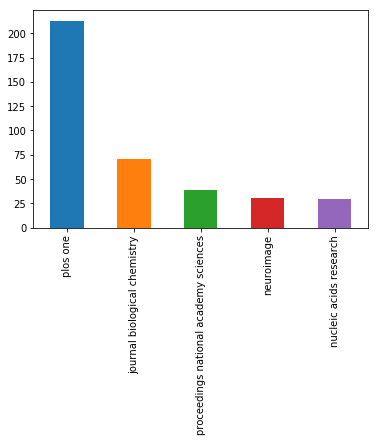

In [97]:
best[:5].plot(kind="bar")

In [124]:
best[:5]

plos one                                 213
journal biological chemistry              71
proceedings national academy sciences     39
neuroimage                                31
nucleic acids research                    29
Name: journal, dtype: int64

In [99]:
for_data = data.join(test, rsuffix='_new',how='inner')

In [100]:
for_data.sample(10)

,publisher,journal,article,cost,journal_new,article_new
1865,The Sheridan Press,Cancer Research,T cell trafficking facilitated by high endothe...,£799.44,cancer research,t cell trafficking facilitated by high endothe...
571,Elsevier,FEBS Open Bio,'CD248 expression on mesenchymal stromal cells...,£1254.25,febs open biological,'cd248 expression on mesenchymal stromal cells...
1121,OUP,Brain,Reading therapy strengthens top-down connectiv...,£2400.00,brain,reading therapy strengthens top-down connectiv...
1833,The American Physiological Society,Journal of Applied Physiology,Development and validation of anthropometric p...,£1288.00,journal applied physiology,development validation anthropometric predicti...
1615,Public Library of Science,PNTD,The outcome of trachomatous trichiasis surgery...,£1488.29,pntd,the outcome trachomatous trichiasis surgery et...
531,Elsevier,Developmental Biology,"The mechanisms of planar cell polarity, growth...",£1981.38,developmental biology,"the mechanisms planar cell polarity, growth hi..."
994,MDPI,Sensors,Wearable and Implantable Sensors: The patientâ...,£1290.41,sensors,wearable implantable sensors: patientâs pers...
1310,PNAS,PNAS USA,Cannabinoid- and lysophosphatidylinositol-sens...,£651.58,proceedings national academy sciences,cannabinoid- lysophosphatidylinositol-sensitiv...
529,Elsevier,Current Opinions in Neurobiology,Updating dopamine reward signals,£2429.17,current opinions neuroscience biology,updating dopamine reward signals
2091,Wiley-Blackwell,Journal of Physiology,Burst activity and ultrafast activation kineti...,£2023.54,journal physiology,burst activity ultrafast activation kinetics c...


In [101]:
fromnew_to_old = for_data.groupby(['journal_new','journal']).agg({'article_new': 'count', 'journal': 'count'})\
.sort_values("article_new",ascending=False)\
.rename(columns={'journal':'journal_count'})\
.reset_index()\
.drop_duplicates(subset=["journal_new"])\
.drop(["article_new","journal_count"],axis=1)

In [102]:
best.to_frame().reset_index().rename(columns={'journal':'journal_count'})\
.merge(fromnew_to_old,left_on='index',right_on="journal_new")\
.drop("index",axis=1).loc[:4][["journal","journal_count"]]

,journal,journal_count
0,PLoS One,213
1,Journal of Biological Chemistry,71
2,Proceedings of the National Academy of Sciences,39
3,Neuroimage,31
4,Nucleic Acids Research,29


In [103]:

for_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2124 entries, 0 to 2126
Data columns (total 6 columns):
publisher      2124 non-null object
journal        2124 non-null object
article        2124 non-null object
cost           2124 non-null object
journal_new    2124 non-null object
article_new    2124 non-null object
dtypes: object(6)
memory usage: 116.2+ KB


In [104]:
for_data[:10].cost

0       £0.00
1    £2381.04
2     £642.56
3     £669.64
4     £685.88
5    £2392.20
6    £2367.95
7     £649.33
8    £1294.59
9    £1294.78
Name: cost, dtype: object

In [105]:
for_data["currency"] = for_data.cost.str.extract(r'([\$|\£])',expand=False)
for_data["value"] = for_data.cost.str.replace(r'([\$|\£])',"")
for_data["value"] = pd.to_numeric(for_data.value)



In [106]:
for_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2124 entries, 0 to 2126
Data columns (total 8 columns):
publisher      2124 non-null object
journal        2124 non-null object
article        2124 non-null object
cost           2124 non-null object
journal_new    2124 non-null object
article_new    2124 non-null object
currency       2124 non-null object
value          2124 non-null float64
dtypes: float64(1), object(7)
memory usage: 149.3+ KB


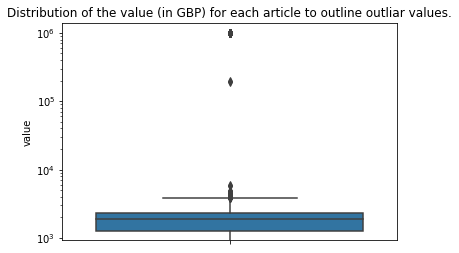

In [107]:
#Looking at the distribution there seems to be a few outliars
g = sns.boxplot(data=for_data,y="value")
g.semilogy()
g.set_title("Distribution of the value (in GBP) for each article to outline outliar values.");

In [108]:
for_data.sort_values("value",ascending=False)[:5]

,publisher,journal,article,cost,journal_new,article_new,currency,value
1566,Public Library of Science,PLoS ONE,Phenotypic alteration of neutrophils in the bl...,£999999.00,plos one,phenotypic alteration neutrophils blood hiv se...,£,999999.0
410,CUP,Journal of the International African Institute,"Pharmacy, money and public health in Dakar.",£999999.00,journal international african institute,"pharmacy, money public health dakar",£,999999.0
1561,Public Library of Science,PLOS ONE,Pharmacological inhibition of caspase-2 protec...,£999999.00,plos one,pharmacological inhibition caspase-2 protects ...,£,999999.0
1562,Public Library of Science,PLoS One,Population-based CD4 counts in a rural area in...,£999999.00,plos one,population-based cd4 counts a rural area south...,£,999999.0
1563,Public Library of Science,PLoS ONE,Plant SILAC: stable-isotope labelling with ami...,£999999.00,plos one,plant silac: stable-isotope labelling with ami...,£,999999.0


In [109]:
for_data.value = for_data.value.replace(999999.0,np.nan)

In [110]:
for_data.sort_values("value",ascending=False)[:5]

,publisher,journal,article,cost,journal_new,article_new,currency,value
1987,Wiley,Movement Disorders,Limb amputations in fixed dystonia: a form of ...,£201024.00,movement disorders,limb amputations fixed dystonia: a form body i...,£,201024.0
1470,Public Library of Science,PLoS One,Reducing stock-outs of life saving Malaria Com...,£192645.00,plos one,reducing stock-outs life saving malaria commod...,£,192645.0
1619,public.service.co.uk,Public Service Review,Laboratory Science in Tropical Medicine,£6000.00,public service review,laboratory science tropical medicine,£,6000.0
800,Elsevier,The Lancet Neurology,Genetic risk factors for ischaemic stroke and ...,£5760.00,the lancet neurology,genetic risk factors for ischaemic stroke its ...,£,5760.0
648,Elsevier,Lancet,Global trends in antiretroviral resistance in ...,£4800.00,lancet,global trends antiretroviral resistance treatm...,£,4800.0


In [111]:
#This looks like the comma was not positionned correctly
for_data.loc[for_data.index==1470,"value"] = 1926.45

for_data.loc[for_data.index==1987,"value"] = 2010.24


In [112]:
for_data.sort_values("value",ascending=True)[:5]

,publisher,journal,article,cost,journal_new,article_new,currency,value
0,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00,psychological medicine,reduced parahippocampal cortical thickness sub...,£,0.00
243,BioMed Central Ltd,Veterinary Research,Understanding foot-and-mouth disease virus tra...,£9.93,veterinary research,understanding foot mouth disease virus transmi...,£,9.93
100,American Society for Nutrition,American Society for Nutrition,The association between breastfeeding and HIV ...,£45.94,american society for nutrition,the association between breastfeeding hiv on p...,£,45.94
1469,Public Library of Science,PLoS One,How well are Malaria Maps used to design and ...,£122.31,plos one,how well are malaria maps used to design finan...,£,122.31
1677,Sciedu Press,Journal of Biomedical Graphics and Computing,Functional MRI demonstrates pain perception in...,£135.29,journal biomedical graphics computing,functional mri demonstrates pain perception ha...,£,135.29


In [113]:
for_data["value"] = for_data["value"].fillna(for_data.groupby("journal_new")["value"].transform("median"))

In [114]:
for_data[for_data.publisher.str.contains("public.*library",case=False)].journal_new.unique()

array(['plos genetics', 'plos one', 'biology', 'computational biology',
       'plos neglected tropical diseases', 'plos computational biology',
       'plos biology', 'plos medicine', 'plos medicine journal',
       'plos pathogens', 'medicine d-12-03130', 'pntd'], dtype=object)

In [115]:

for_data["value"] = for_data["value"].fillna(np.median(for_data[~for_data.value.isna()].value))

In [116]:
for_data.sort_values("value",ascending=False)[:10]

,publisher,journal,article,cost,journal_new,article_new,currency,value
1619,public.service.co.uk,Public Service Review,Laboratory Science in Tropical Medicine,£6000.00,public service review,laboratory science tropical medicine,£,6000.00
800,Elsevier,The Lancet Neurology,Genetic risk factors for ischaemic stroke and ...,£5760.00,the lancet neurology,genetic risk factors for ischaemic stroke its ...,£,5760.00
552,Elsevier,Elsevier,Effects of relative weight gain and linear gro...,£4800.00,elsevier,effects relative weight gain linear growth dur...,£,4800.00
798,Elsevier,The Lancet,Effects of unconditional and conditional cash ...,£4800.00,the lancet,effects unconditional conditional cash transfe...,£,4800.00
648,Elsevier,Lancet,Global trends in antiretroviral resistance in ...,£4800.00,lancet,global trends antiretroviral resistance treatm...,£,4800.00
797,Elsevier,The Lancet,The impact on a serogroup a meningococcal conj...,£4554.01,the lancet,the impact on a serogroup a meningococcal conj...,£,4554.01
799,Elsevier,The Lancet Neurology,MRI investigation of the sensorimotor cortex a...,£4320.00,the lancet neurology,mri investigation sensorimotor cortex corticos...,£,4320.00
796,Elsevier,The Lancet,Dementia incidence and mortality in middle inc...,£4320.00,the lancet,dementia incidence mortality middle income cou...,£,4320.00
844,Elsevier/Cell Press,Cell Host & Microbe,Human cytomegalovirus UL141 targets the TRAIL ...,£4226.04,cell host microbe,human cytomegalovirus ul141 targets trail deat...,£,4226.04
729,Elsevier,Neuron,"Distinct contributions of rod, cone, and melan...",£4170.35,neuron,"distinct contributions rod, cone, melanopsin p...",£,4170.35


In [122]:
group_information = for_data.groupby('journal_new').agg({'article_new': 'count', 'value': ["mean","median","std"]}).sort_values(("article_new","count"),ascending=False)

In [129]:
fromnew_to_old

,journal_new,journal
0,plos one,PLoS One
2,journal biological chemistry,Journal of Biological Chemistry
3,nucleic acids research,Nucleic Acids Research
4,proceedings national academy sciences,Proceedings of the National Academy of Sciences
5,plos neglected tropical diseases,PLoS Neglected Tropical Diseases
6,human molecular genetics,Human Molecular Genetics
7,nature communications,Nature Communications
8,plos genetics,PLoS Genetics
9,plos pathogens,PLoS Pathogens
10,neuroimage,Neuroimage


<a id="part_two"></a>
# Part two : calculate the mean, median, and standard deviation of the open-access cost per article for each journal.

We replace error values with the median for the journal.
Final result is below, 


In [145]:
group_information[group_information.index.isin(best[:5].index)].reset_index()\
.merge(fromnew_to_old,on="journal_new")[[('article_new', 'count'),        ('value', 'mean'),
            ('value', 'median'),         ('value', 'std'),
                      'journal']]

/Users/severinhatt/Virtualenvs/thinkful/base_plotting/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(article_new, count)","(value, mean)","(value, median)","(value, std)",journal
0,213,941.465516,898.475,200.563194,PLoS One
1,71,1383.787183,1314.530,385.049651,Journal of Biological Chemistry
2,39,840.169231,742.920,455.253647,Proceedings of the National Academy of Sciences
3,31,2212.181290,2326.430,273.193244,Neuroimage
4,29,1162.344828,852.000,442.150934,Nucleic Acids Research


In [119]:
for_data.describe()

,value
count,2124.000000
mean,1822.317349
std,768.503081
min,0.000000
25%,1268.465000
50%,1850.000000
75%,2298.792500
max,6000.000000


In [147]:
for_data[for_data.journal_new.isin(best[:5].index)]

,publisher,journal,article,cost,journal_new,article_new,currency,value
16,AMBSB,Journal of Biological Chemistry,Annexin-1 interaction with FPR2/ALX,£265.67,journal biological chemistry,annexin-1 interaction with fpr2/alx,£,265.670
60,American Soc for Biochemistry and Molecular Bi...,Journal of Biological Chemistry,Understanding how noncatalytic carbohydrate bi...,£1100.00,journal biological chemistry,understanding how noncatalytic carbohydrate bi...,£,1100.000
61,American Society for Biochemistry and Molecula...,Journal of Biological Chemistry,Molecular architecture and functional analysis...,£2259.64,journal biological chemistry,molecular architecture functional analysis net...,£,2259.640
62,American Society for Biochemistry and Molecula...,J Biol Chem.,Structure of the BMP receptor ALK2 and implica...,£1487.46,journal biological chemistry,structure bmp receptor alk2 implications for f...,£,1487.460
63,American Society for Biochemistry and Molecula...,J Biol Chem.,Inhibitory member of the apoptosis-stimulating...,£1531.08,journal biological chemistry,inhibitory member apoptosis-stimulating protei...,£,1531.080
64,American Society for Biochemistry and Molecula...,Journal of Biological Chemistry,Human and viral golgi anti-apoptotic protein (...,£1019.71,journal biological chemistry,human viral golgi anti-apoptotic protein (gaap...,£,1019.710
65,American Society for Biochemistry and Molecula...,Journal of Biological Chemistry,Dynamic exchange of myosin VI on endocytic str...,£1119.61,journal biological chemistry,dynamic exchange myosin vi on endocytic struct...,£,1119.610
66,American Society for Biochemistry and Molecula...,Journal of Biological Chemistry,Uncoupling proteostasis and development in vit...,£1131.01,journal biological chemistry,uncoupling proteostasis development vitro with...,£,1131.010
67,American Society for Biochemistry and Molecula...,Journal of Biological Chemistry,Structural Requirements for Recognition of Maj...,£1137.51,journal biological chemistry,structural requirements for recognition major ...,£,1137.510
68,American Society for Biochemistry and Molecula...,Journal of Biological Chemistry,Visualization of structural changes accompanyi...,£1152.72,journal biological chemistry,visualization structural changes accompanying ...,£,1152.720


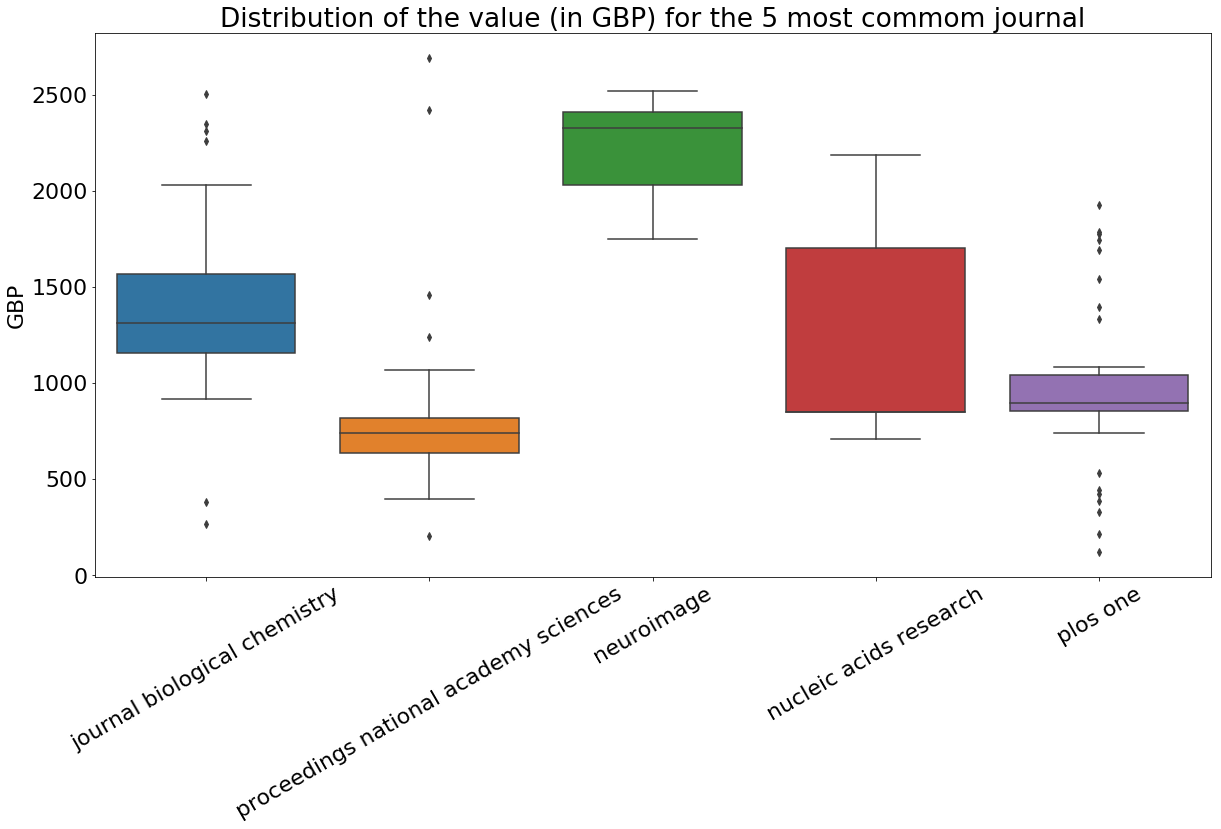

In [157]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 22})
g = sns.violinplot(data=for_data[for_data.journal_new.isin(best[:5].index)],y="value",x='journal_new',scale : {“area”, “count”)
g.set_title("Distribution of the value (in GBP) for the 5 most commom journal");
g.set_xlabel("");
g.set_ylabel("GBP");
plt.xticks(rotation=30);
# Any results you write to the current d

In [307]:
for_data.value.sum()

3871557.165